In [1]:
%load_ext autoreload
%autoreload 2

import nest
import sys
import os.path
import numpy as np
from math import degrees
import matplotlib.pyplot as plt

sys.path.append('../')
import params
import nest_tools
import mnist_tools

# reseed numpy
np.random.seed(0)

# create samples

# load data - some preprocessing is done in the module (reshaping)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = mnist_tools.load_mnist_data('../mnist.pkl.gz')

# create pixel samples
pixel_samples = mnist_tools.create_samples(4000, sample_size=40)

######### rate 15000.000000000004


## Calculation of input entropy


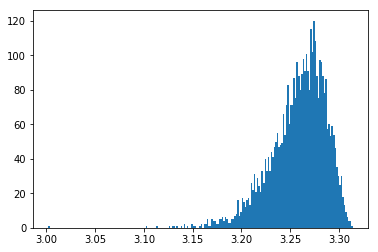

In [2]:
# samples for each neuron
digits = np.concatenate([ mnist_tools.get_sample_digits(x_train, y_train, 10, i) for i in range(10) ])
digit_labels = np.concatenate([ [i//10] for i in range(100) ])

vectors = mnist_tools.digit_to_vectors(digits, pixel_samples)

activations = np.sum(vectors, axis=2)
mean_activations_per_digit =  mnist_tools.mean_rates_per_digit(digit_labels, activations)
input_entropies = mnist_tools.calc_entropies(mean_activations_per_digit)
    
plt.figure()
plt.hist(input_entropies, bins=200)
None

In [3]:
def simulate(rates, digits, digit_labels, name, duration=1000.0):
    network = nest_tools.Network()
    network.reset_nest()
    network.setup_static_network()
    network.record_spikes(name)
    
    for i, digit in enumerate(digits):
        # set rate for every neuron

        for j, rate in enumerate(rates[i]):
            network.set_rate([j+1], rate)

        print(str(i+1)+". stimulus = "+str(digit_labels[i])+", simulating for", duration)
        nest.Simulate(duration)

    network.save_recording(name)

## Inspection of population firing depending on different standardization

These spike recordings use a) standardization per sample and b) standardization over all input activations

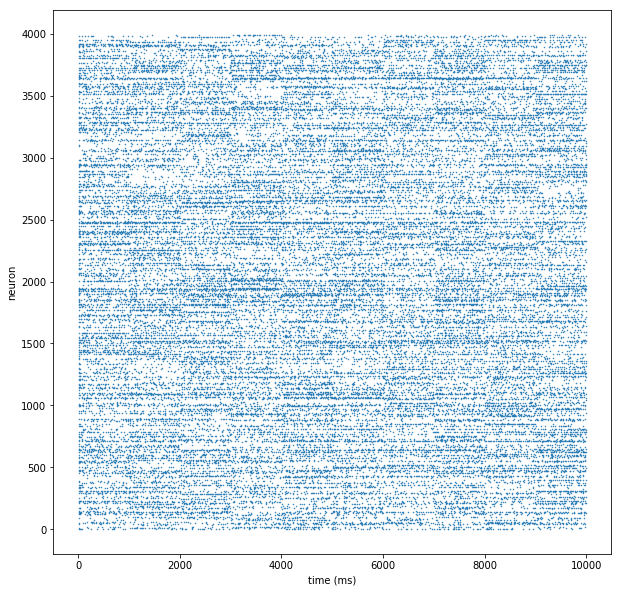

In [4]:
test_digits = x_train[:10]
test_labels = y_train[:10]

input_rates = mnist_tools.calc_rates(test_digits, pixel_samples, standardize_per_digit=True) * params.rate

if not os.path.exists('firing1.0.npy'):
    simulate(input_rates, test_digits, test_labels, 'firing1')

recording = nest_tools.SpikeRecording.from_file('firing1')

# plot every 10th neuron
plt.figure(figsize=(10,10))
recording.plot(neurons=range(1,4000,10))
    

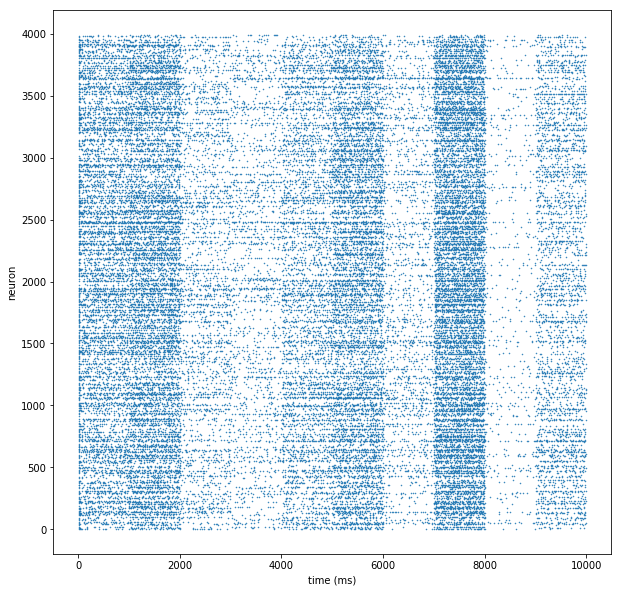

In [5]:
input_rates = mnist_tools.calc_rates(test_digits, pixel_samples, standardize_per_digit=False) * params.rate

if not os.path.exists('firing2.0.npy'):
    simulate(input_rates, test_digits, test_labels, 'firing2')
recording = nest_tools.SpikeRecording.from_file('firing2')

# plot every 10th neuron
plt.figure(figsize=(10,10))
recording.plot(neurons=range(1,4000,10))


## Experiment 1

Run the network on one sample of the input digits 0, 1, 2, 3, ... , 9 each - then calculate the entropy for each neuron at the input and at the output and compare.

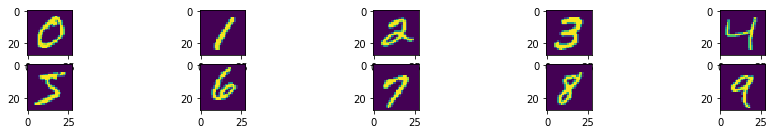

In [6]:
# create training set
digits = np.concatenate([ mnist_tools.get_sample_digits(x_train, y_train, 10, i) for i in range(10) ])
digit_labels = np.concatenate([ [i//10] for i in range(100) ])

digits = np.concatenate([ mnist_tools.get_sample_digits(x_train, y_train, 1, i) for i in range(10) ])
digit_labels = np.concatenate([ [i] for i in range(10) ])

plt.figure(figsize=(15,40))
for i, digit in enumerate(digits):
    plt.subplot(40,5, i+1)
    plt.imshow(digit)

In [7]:
input_rates = mnist_tools.calc_rates(digits, pixel_samples, standardize_per_digit=True) * params.rate
mean_input_rates_per_digit =  mnist_tools.mean_rates_per_digit(digit_labels, input_rates)
input_entropies = mnist_tools.calc_entropies(mean_input_rates_per_digit)
    
if not os.path.exists('experiment1.0.npy'):
    simulate(input_rates, digits, digit_labels, 'experiment1')

recording = nest_tools.SpikeRecording.from_file('experiment1')
    
output_rates = np.stack([recording.rate(range(1,4001), i*1000, (i+1)*1000.0) for i in range(len(digits))])
mean_output_rates_per_digit =  mnist_tools.mean_rates_per_digit(digit_labels, output_rates)
output_entropies = mnist_tools.calc_entropies(mean_output_rates_per_digit)


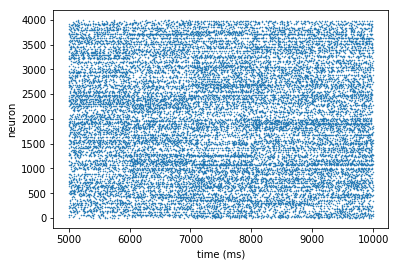

In [8]:
recording.plot(neurons=range(1,4000,10), start=5000, end=10000)

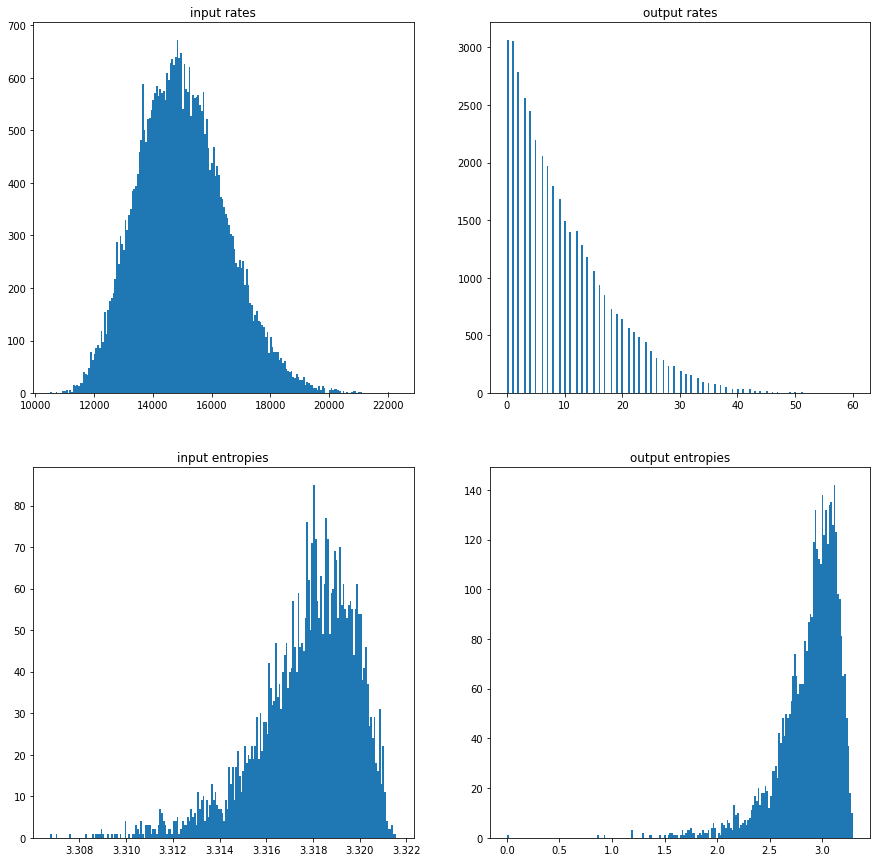

In [9]:
plt.figure(figsize=(15,15))
    
plt.subplot(2,2,1)
plt.title("input rates")
plt.hist(input_rates.ravel(), bins=200)

plt.subplot(2,2,2)
plt.title("output rates")
plt.hist(output_rates.ravel(), bins=200)
   
plt.subplot(2,2,3)
plt.title("input entropies")
plt.hist(input_entropies, bins=200)

plt.subplot(2,2,4)
plt.title("output entropies")
plt.hist(output_entropies, bins=200)
None

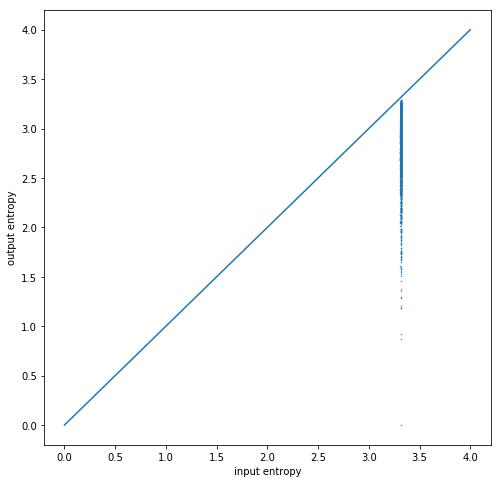

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(input_entropies, output_entropies, s=0.2)
plt.xlabel("input entropy")
plt.ylabel("output entropy")
plt.plot([0,4], [0,4])

## Experiment 2

Run the network on ten samples of the input digits 0, 1, 2, 3, ... , 9 each - then calculate the entropy for each neuron at the input and at the output and compare.

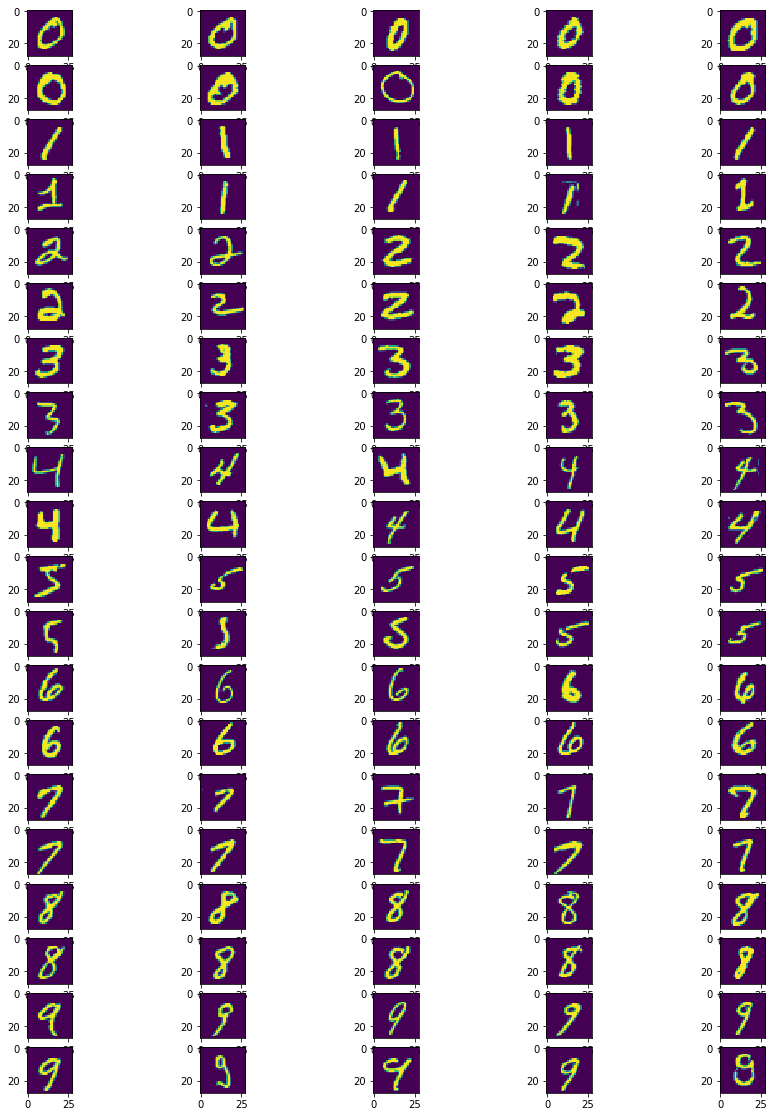

In [11]:
# create training set
digits = np.concatenate([ mnist_tools.get_sample_digits(x_train, y_train, 10, i) for i in range(10) ])
digit_labels = np.concatenate([ [i//10] for i in range(100) ])

plt.figure(figsize=(15,40))
for i, digit in enumerate(digits):
    plt.subplot(40,5, i+1)
    plt.imshow(digit)

In [12]:
input_rates = mnist_tools.calc_rates(digits, pixel_samples, standardize_per_digit=True) * params.rate
mean_input_rates_per_digit =  mnist_tools.mean_rates_per_digit(digit_labels, input_rates)
input_entropies = mnist_tools.calc_entropies(mean_input_rates_per_digit)

if not os.path.exists('experiment2.0.npy'):
    simulate(input_rates, digits, digit_labels, 'experiment2')
recording = nest_tools.SpikeRecording.from_file('experiment2')

    
output_rates = np.stack([recording.rate(range(1,4001), i*1000, (i+1)*1000.0) for i in range(len(digits))])
mean_output_rates_per_digit = mnist_tools.mean_rates_per_digit(digit_labels, output_rates)
output_entropies = mnist_tools.calc_entropies(mean_output_rates_per_digit)


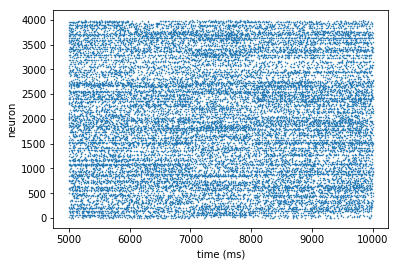

In [13]:
recording.plot(neurons=range(1,4000,10), start=5000, end=10000)

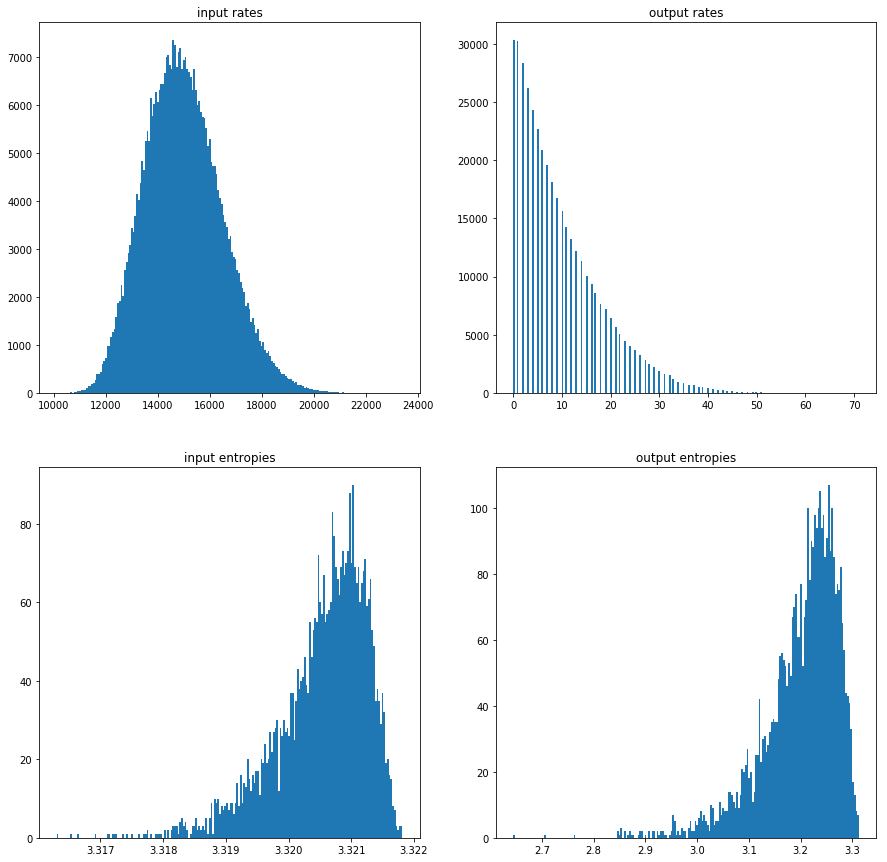

In [14]:
plt.figure(figsize=(15,15))
    
plt.subplot(2,2,1)
plt.title("input rates")
plt.hist(input_rates.ravel(), bins=200)

plt.subplot(2,2,2)
plt.title("output rates")
plt.hist(output_rates.ravel(), bins=200)
   
plt.subplot(2,2,3)
plt.title("input entropies")
plt.hist(input_entropies, bins=200)

plt.subplot(2,2,4)
plt.title("output entropies")
plt.hist(output_entropies, bins=200)
None

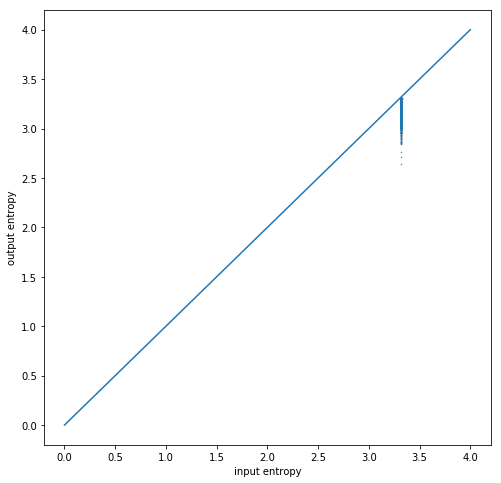

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(input_entropies, output_entropies, s=0.2)
plt.xlabel("input entropy")
plt.ylabel("output entropy")
plt.plot([0,4], [0,4])

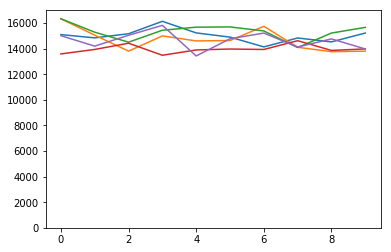

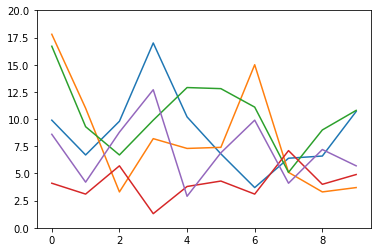

In [16]:
for i in range(5):
    plt.plot(mean_input_rates_per_digit[:,i])
    plt.ylim([0, 17000])


plt.figure()
for i in range(5):
    plt.plot(mean_output_rates_per_digit[:,i])
    plt.ylim([0,20])



## Experiment 3 - same as 2, but without standardization per digit

In [17]:
input_rates = mnist_tools.calc_rates(digits, pixel_samples, standardize_per_digit=False) * params.rate
mean_input_rates_per_digit =  mnist_tools.mean_rates_per_digit(digit_labels, input_rates)
input_entropies = mnist_tools.calc_entropies(mean_input_rates_per_digit)

if not os.path.exists('experiment3.0.npy'):
    simulate(input_rates, digits, digit_labels, 'experiment3')
recording = nest_tools.SpikeRecording.from_file('experiment3')

    
output_rates = np.stack([recording.rate(range(1,4001), i*1000, (i+1)*1000.0) for i in range(len(digits))])
mean_output_rates_per_digit = mnist_tools.mean_rates_per_digit(digit_labels, output_rates)
output_entropies = mnist_tools.calc_entropies(mean_output_rates_per_digit)


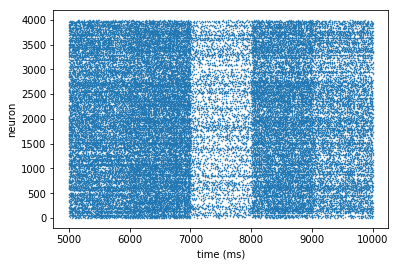

In [18]:
recording.plot(neurons=range(1,4000,10), start=5000, end=10000)

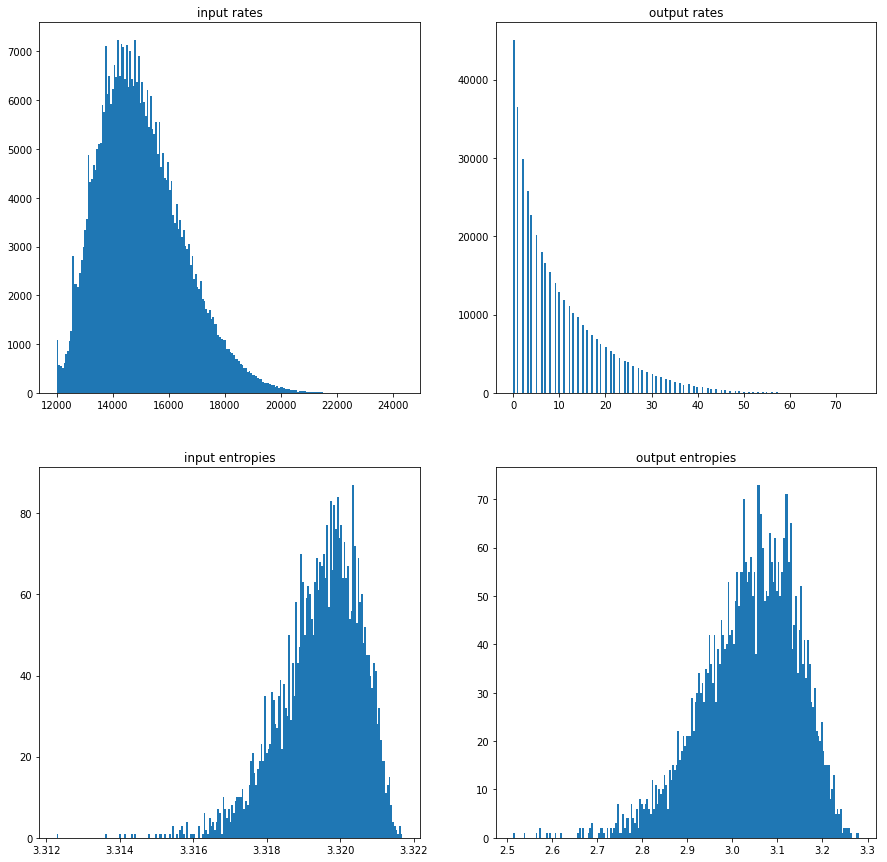

In [19]:
plt.figure(figsize=(15,15))
    
plt.subplot(2,2,1)
plt.title("input rates")
plt.hist(input_rates.ravel(), bins=200)

plt.subplot(2,2,2)
plt.title("output rates")
plt.hist(output_rates.ravel(), bins=200)
   
plt.subplot(2,2,3)
plt.title("input entropies")
plt.hist(input_entropies, bins=200)

plt.subplot(2,2,4)
plt.title("output entropies")
plt.hist(output_entropies, bins=200)
None

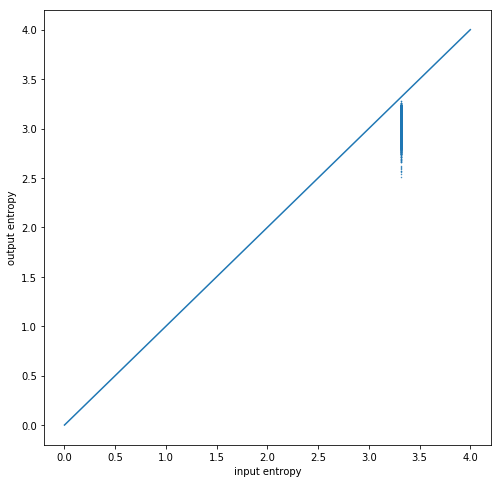

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(input_entropies, output_entropies, s=0.2)
plt.xlabel("input entropy")
plt.ylabel("output entropy")
plt.plot([0,4], [0,4])